Linear Model Coefficients: θ0=[6.39194128e-05], θ1=3.9404256316795236


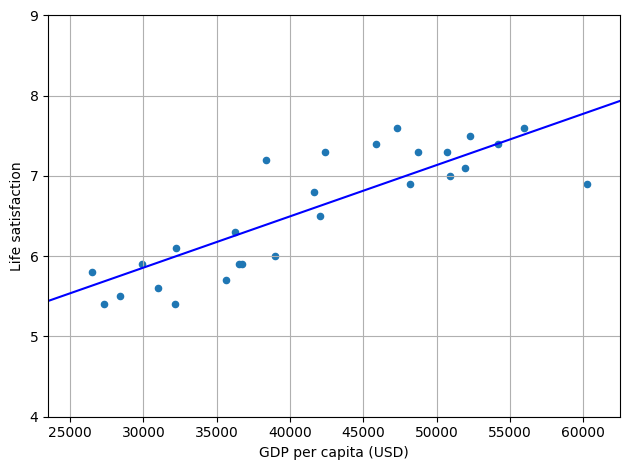

Best model alpha: 0.001, score: 0.849894656260013


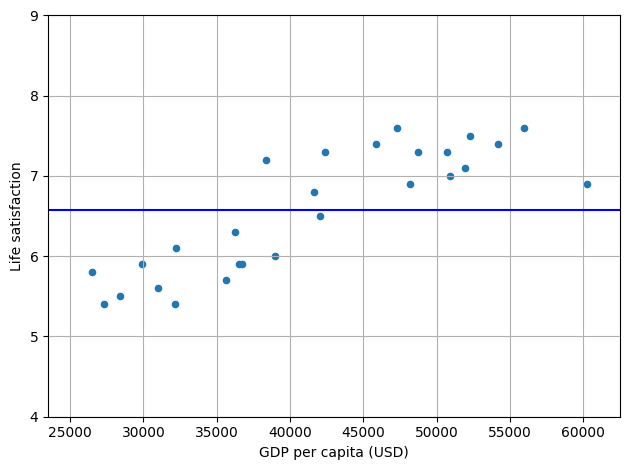

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from pathlib import Path
import urllib.request

# Constants
DATA_ROOT = "https://github.com/ageron/data/raw/main/"
MIN_GDP, MAX_GDP = 23_500, 62_500
MIN_LIFE_SAT, MAX_LIFE_SAT = 4, 9

# Utility Functions
def download_datasets():
    """Download the required datasets if not already present."""
    datapath = Path("datasets/lifesat")
    datapath.mkdir(parents=True, exist_ok=True)

    dataset_files = ["oecd_bli.csv", "gdp_per_capita.csv"]

    for filename in dataset_files:
        file_path = datapath / filename
        if not file_path.is_file():
            print(f"Downloading {filename}...")
            url = f"{DATA_ROOT}lifesat/{filename}"
            urllib.request.urlretrieve(url, file_path)

    return datapath

def load_and_clean_data(datapath):
    """Load and clean OECD and GDP data, return a cleaned merged DataFrame."""
    # Load datasets
    oecd_bli = pd.read_csv(datapath / "oecd_bli.csv")
    gdp_per_capita = pd.read_csv(datapath / "gdp_per_capita.csv")

    # Filter GDP data for 2020 and clean up columns
    gdp_per_capita = gdp_per_capita[gdp_per_capita["Year"] == 2020].drop(["Code", "Year"], axis=1)
    gdp_per_capita.columns = ["Country", "GDP per capita (USD)"]
    gdp_per_capita.set_index("Country", inplace=True)

    # Filter OECD data for total inequality and pivot table for life satisfaction
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"] == "TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

    # Merge datasets and select relevant columns
    country_stats = pd.merge(oecd_bli, gdp_per_capita, left_index=True, right_index=True)
    country_stats = country_stats[["GDP per capita (USD)", "Life satisfaction"]]

    return country_stats

def plot_data(country_stats, model=None, X_vals=None, theta_0=None, theta_1=None, fig_name=None):
    """Plot GDP per capita against Life Satisfaction with optional model predictions."""
    country_stats.plot(kind='scatter', x="GDP per capita (USD)", y="Life satisfaction", grid=True)

    if model and X_vals is not None:
        plt.plot(X_vals, model.predict(X_vals[:, np.newaxis]), color="blue", label="Model Prediction")

    if theta_0 is not None and theta_1 is not None:
        X = np.linspace(MIN_GDP, MAX_GDP, 1000)
        plt.plot(X, theta_0 + theta_1 * X, color="red", label="Manual Model")

    plt.axis([MIN_GDP, MAX_GDP, MIN_LIFE_SAT, MAX_LIFE_SAT])

    if fig_name:
        save_figure(fig_name)

    plt.show()

def save_figure(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    """Save the current plot to a file."""
    image_path = Path("images/fundamentals")
    image_path.mkdir(parents=True, exist_ok=True)

    path = image_path / f"{fig_name}.{fig_extension}"

    if tight_layout:
        plt.tight_layout()

    plt.savefig(path, format=fig_extension, dpi=resolution)

# GDP Model Class
class GDPModel:
    """Class for fitting and predicting life satisfaction using different regression models."""

    def __init__(self, model=LinearRegression(), polynomial_degree=None):
        self.model = model
        self.pipeline = None

        if polynomial_degree:
            self.pipeline = Pipeline([
                ('polynomial_features', PolynomialFeatures(degree=polynomial_degree, include_bias=False)),
                ('scaler', StandardScaler()),
                ('regression', model)
            ])

    def fit(self, X, y):
        """Fit the model to the data."""
        if self.pipeline:
            self.pipeline.fit(X, y)
        else:
            self.model.fit(X, y)

    def predict(self, X):
        """Predict using the fitted model."""
        if self.pipeline:
            return self.pipeline.predict(X)
        return self.model.predict(X)

    def get_params(self):
        """Return model coefficients and intercept."""
        if self.pipeline:
            return self.pipeline.named_steps['regression'].coef_, self.pipeline.named_steps['regression'].intercept_
        return self.model.coef_, self.model.intercept_

    def fine_tune(self, X_train, y_train, X_val, y_val, n_samples=5):
        """Fine-tune model parameters using a subset of alpha values."""
        best_model = None
        best_score = float('-inf')

        # Randomly sample alpha values for faster evaluation
        alpha_values = np.logspace(-3, 3, n_samples)

        for alpha in alpha_values:
            model = Ridge(alpha=alpha)
            model.fit(X_train, y_train)
            score = model.score(X_val, y_val)

            if score > best_score:
                best_score = score
                best_model = model

        self.model = best_model
        print(f"Best model alpha: {best_model.alpha}, score: {best_score}")

# Main Workflow
def main():
    # Download and load data
    datapath = download_datasets()
    country_stats = load_and_clean_data(datapath)

    # Filter data within specified GDP range
    filtered_stats = country_stats[(country_stats["GDP per capita (USD)"] >= MIN_GDP) &
                                   (country_stats["GDP per capita (USD)"] <= MAX_GDP)]

    # Prepare input/output data
    X = filtered_stats[["GDP per capita (USD)"]].values
    y = filtered_stats[["Life satisfaction"]].values

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear Regression Model
    linear_model = GDPModel(LinearRegression())
    linear_model.fit(X_train, y_train)

    theta_0, theta_1 = linear_model.get_params()
    print(f"Linear Model Coefficients: θ0={theta_0[0]}, θ1={theta_1[0]}")

    # Plot linear regression results
    X_vals = np.linspace(MIN_GDP, MAX_GDP, 1000)
    plot_data(filtered_stats, model=linear_model, X_vals=X_vals, fig_name="linear_model_plot")

    # Fine-tune the model
    linear_model.fine_tune(X_train, y_train, X_val, y_val)

    # Polynomial Regression with Ridge Regularization
    poly_ridge_model = GDPModel(Ridge(alpha=10**9.5), polynomial_degree=10)
    poly_ridge_model.fit(X_train, y_train)

    # Plot polynomial regression results
    plot_data(filtered_stats, model=poly_ridge_model, X_vals=X_vals, fig_name="poly_ridge_model_plot")

if __name__ == "__main__":
    main()
